# **TRABELSI BECHIR SUBMISSION FOR TECHNICAL TEST **
**M2 DATA SCIENCE ECOLE POLYTECHNIQUE/INSTITUT POLYTECHNIQUE DE PARIS**


**This notebook will be in english for accessibility puroposes**. 

Let us start by importing some libraries that we'll use

In [2]:
import pandas as pd 
from sklearn.decomposition import PCA 
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize,StandardScaler


Now we load our data 

In [3]:
df = pd.read_csv("https://github.com/BechirTr/Some_Projects/raw/main/Dataset.csv", sep=",")

In [4]:
df.head()

,ID,URL,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,IMAGES,SURFACE,LAND_SURFACE,BALCONY_SURFACE,TERRACE_SURFACE,ROOM_COUNT,BEDROOM_COUNT,BATHROOM_COUNT,LUNCHROOM_COUNT,TOILET_COUNT,FURNISHED,FIREPLACE,AIR_CONDITIONING,GARDEN,SWIMMING_POOL,BALCONY,TERRACE,CELLAR,PARKING,PARKING_COUNT,HEATING_TYPES,HEATING_MODE,FLOOR,FLOOR_COUNT,CONSTRUCTION_YEAR,ELEVATOR,CARETAKER,ENERGY_CONSUMPTION,GREENHOUSE_GAS_CONSUMPTION,MARKETING_TYPE,PRICE,PRICE_M2,PRICE_EVENTS,RENTAL_EXPENSES,RENTAL_EXPENSES_INCLUDED,DEPOSIT,FEES,FEES_INCLUDED,EXCLUSIVE_MANDATE,AGENCIES_UNWANTED,OCCUPIED,DEALER_NAME,DEALER_TYPE,CITY_ID,CITY,ZIP_CODE,DEPT_CODE,PUBLICATION_START_DATE,PUBLICATION_END_DATE,LAST_CRAWL_DATE,LAST_PRICE_DECREASE_DATE
0,22c05930-0eb5-11e7-b53d-bbead8ba43fe,http://www.avendrealouer.fr/location/levallois...,A_VENDRE_A_LOUER,APARTMENT,False,"Au rez de chaussée d'un bel immeuble récent,ap...","[""https://cf-medias.avendrealouer.fr/image/_87...",72.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0,[],COLLECTIVE,NaN,NaN,NaN,True,NaN,NaN,NaN,RENT,1979.0,27.49,"[{""price"":1979,""date"":""2017-03-22""}]",276.0,True,NaN,NaN,NaN,False,NaN,NaN,Lamirand Et Associes,AGENCY,54178039,Levallois-Perret,92300.0,92,2017-03-22T04:07:56.095,NaN,2017-04-21T18:52:35.733,NaN
1,8d092fa0-bb99-11e8-a7c9-852783b5a69d,https://www.bienici.com/annonce/ag440414-16547...,BIEN_ICI,APARTMENT,False,Je vous propose un appartement dans la rue Col...,"[""http://photos.ubiflow.net/440414/165474561/p...",48.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,False,NaN,[],INDIVIDUAL,1.0,6.0,NaN,True,False,NaN,NaN,SALE,429000.0,8937.50,"[{""price"":452000.0,""date"":""2018-09-18""},{""pric...",NaN,NaN,NaN,NaN,False,False,NaN,False,Proprietes Privees,MANDATARY,54178039,Levallois-Perret,92300.0,92,2018-09-18T11:04:44.461,NaN,2019-06-06T10:08:10.89,2018-09-25
2,44b6a5c0-3466-11e9-8213-25cc7d9bf5fc,https://www.bellesdemeures.com/annonces/vente/...,BELLES_DEMEURES,APARTMENT,False,"Dans un cadre arboré, calme et fleuri, un pent...","[""https://v.seloger.com/s/width/965/visuels/0/...",267.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SALE,4970000.0,18614.23,"[{""price"":4970000.0,""date"":""2019-02-19""}]",NaN,NaN,NaN,NaN,NaN,False,NaN,False,Propriétés Parisiennes,AGENCY,54178039,Levallois-Perret,92300.0,92,2019-02-19T16:49:03.547,NaN,2019-06-13T08:22:14.314,NaN
3,e9e07ed0-812f-11e8-82aa-61eacebe4584,https://www.seloger.com/annonces/locations/bur...,SE_LOGER,PREMISES,False,"""Le meilleur coworking flexible de la ville, 5...","[""https://pix.yanport.com/ads/e9e07ed0-812f-11...",50.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RENT,89.0,1.78,"[{""price"":89.0,""date"":""2018-07-06""}]",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,Iwg,AGENCY,54178039,Levallois-Perret,92300.0,92,2018-07-06T15:18:59.805,NaN,2019-06-18T10:40:07.405,NaN
4,872302b0-5a21-11e9-950c-510fefc1ed35,https://www.bellesdemeures.com/annonces/vente/...,BELLES_DEMEURES,HOUSE,False,Levallois - Parc de la Planchette A toute prox...,"[""https://v.seloger.com/s/width/966/visuels/0/...",330.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SALE,2790000.0,8454.55,"[{""price"":3150000.0,""date"":""2019-04-08""},{""pri...",NaN,NaN,NaN,NaN,NaN,False,NaN,False,Daniel Feau Neuilly,AGENCY,54178039,Levallois-Perret,92300.0,92,2019-04-08T17:12:20.123,NaN,2019-06-14T15:02:18.155,2019-06-14


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          2164 non-null   object 
 1   URL                         2164 non-null   object 
 2   CRAWL_SOURCE                2164 non-null   object 
 3   PROPERTY_TYPE               2164 non-null   object 
 4   NEW_BUILD                   1973 non-null   object 
 5   DESCRIPTION                 2160 non-null   object 
 6   IMAGES                      2164 non-null   object 
 7   SURFACE                     2050 non-null   float64
 8   LAND_SURFACE                3 non-null      float64
 9   BALCONY_SURFACE             0 non-null      float64
 10  TERRACE_SURFACE             25 non-null     float64
 11  ROOM_COUNT                  1835 non-null   float64
 12  BEDROOM_COUNT               696 non-null    float64
 13  BATHROOM_COUNT              0 non

We can observe the data is not clean and with lots of nan values, we will proceed to some preprocessing and cleaning tasks.

First we will drop all columns with a total of nan values greater than 50% of the total number of observations.

In [6]:
df = df.dropna(axis=1,thresh=1200)
id=df["ID"].tolist()

Next will will create dummy columns to encode the categorical variables in our data frame so that we can feed it to an estimator later.

In [7]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()
obj_df=pd.get_dummies(obj_df, columns=['CRAWL_SOURCE', 'PROPERTY_TYPE',
       'MARKETING_TYPE',
      'OCCUPIED', 'DEALER_TYPE'])

obj_df=obj_df.select_dtypes(exclude=['object']) 

Now we merge the two dataframes and we drop all the remaining categorical variables, and we convert the booleans to integers.

Moreover since all the ads are located in the same city we can drop the 'CITY_ID', 'ZIP_CODE', 'DEPT_CODE' columns as well, as they are not significative in our case. 

In [8]:
df=pd.concat([df,obj_df],axis=1)
for (name,data) in df.iteritems():
    if  df[name].dtype == "bool":
        df[name] = df[name].astype(int)
df=df.select_dtypes(exclude=['object']) 
df=df.drop(['CITY_ID', 'ZIP_CODE', 'DEPT_CODE'],axis='columns')
old_df=df.copy()

Now lets observe our new dataframe.

In [9]:
df.describe()

,SURFACE,ROOM_COUNT,PARKING,PRICE,PRICE_M2,EXCLUSIVE_MANDATE,CRAWL_SOURCE_A_VENDRE_A_LOUER,CRAWL_SOURCE_BELLES_DEMEURES,CRAWL_SOURCE_BIEN_ICI,CRAWL_SOURCE_EXPLORIMMO,CRAWL_SOURCE_LE_BON_COIN,CRAWL_SOURCE_LOGIC_IMMO,CRAWL_SOURCE_LUX_RESIDENCE,CRAWL_SOURCE_MEILLEURS_AGENTS,CRAWL_SOURCE_PAP,CRAWL_SOURCE_PARU_VENDU,CRAWL_SOURCE_PROPRIETES_DE_FRANCE,CRAWL_SOURCE_SE_LOGER,CRAWL_SOURCE_SURFACE_PRIVEE,PROPERTY_TYPE_APARTMENT,PROPERTY_TYPE_BUILDING,PROPERTY_TYPE_HOUSE,PROPERTY_TYPE_PARKING,PROPERTY_TYPE_PREMISES,MARKETING_TYPE_RENT,MARKETING_TYPE_SALE,OCCUPIED_False,OCCUPIED_True,DEALER_TYPE_AGENCY,DEALER_TYPE_MANDATARY,DEALER_TYPE_PRIVATE
count,2050.000000,1835.000000,2164.000000,2.104000e+03,1991.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000
mean,128.136068,2.243597,0.072551,4.261142e+05,5483.773420,0.077172,0.096118,0.008780,0.082255,0.090573,0.113678,0.063309,0.003235,0.089187,0.022643,0.014325,0.009704,0.405268,0.000924,0.663586,0.004159,0.024030,0.086876,0.221349,0.436691,0.563309,0.549445,0.009242,0.856747,0.050370,0.092884
std,423.339898,1.715621,0.259458,6.486603e+05,5384.760624,0.266926,0.294822,0.093311,0.274816,0.287067,0.317494,0.243574,0.056796,0.285079,0.148798,0.118856,0.098054,0.491057,0.030394,0.472592,0.064371,0.153176,0.281719,0.415251,0.496090,0.496090,0.497664,0.095713,0.350412,0.218757,0.290336
min,6.000000,0.000000,0.000000,3.300000e+01,1.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.200000,1.000000,0.000000,1.600000e+03,32.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,55.000000,2.000000,0.000000,2.200000e+05,7586.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,93.000000,3.000000,0.000000,6.097500e+05,10056.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,10287.000000,10.000000,1.000000,6.000000e+06,89000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that the statistical dispersion of the data is pretty high, which will surely affect the quality of any estimator we use, as such we proceed to standardize our data frame.

In [10]:
scaler=StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(old_df), columns=old_df.columns)
df_scaled.describe()

,SURFACE,ROOM_COUNT,PARKING,PRICE,PRICE_M2,EXCLUSIVE_MANDATE,CRAWL_SOURCE_A_VENDRE_A_LOUER,CRAWL_SOURCE_BELLES_DEMEURES,CRAWL_SOURCE_BIEN_ICI,CRAWL_SOURCE_EXPLORIMMO,CRAWL_SOURCE_LE_BON_COIN,CRAWL_SOURCE_LOGIC_IMMO,CRAWL_SOURCE_LUX_RESIDENCE,CRAWL_SOURCE_MEILLEURS_AGENTS,CRAWL_SOURCE_PAP,CRAWL_SOURCE_PARU_VENDU,CRAWL_SOURCE_PROPRIETES_DE_FRANCE,CRAWL_SOURCE_SE_LOGER,CRAWL_SOURCE_SURFACE_PRIVEE,PROPERTY_TYPE_APARTMENT,PROPERTY_TYPE_BUILDING,PROPERTY_TYPE_HOUSE,PROPERTY_TYPE_PARKING,PROPERTY_TYPE_PREMISES,MARKETING_TYPE_RENT,MARKETING_TYPE_SALE,OCCUPIED_False,OCCUPIED_True,DEALER_TYPE_AGENCY,DEALER_TYPE_MANDATARY,DEALER_TYPE_PRIVATE
count,2.050000e+03,1.835000e+03,2.164000e+03,2.104000e+03,1.991000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03
mean,-6.471788e-17,1.653234e-17,2.049603e-16,-2.516338e-18,7.895911e-17,7.928039e-16,7.859804e-17,-1.877734e-16,2.897662e-16,6.156505e-18,4.861587e-16,-2.716558e-17,-2.567711e-16,-2.335881e-16,-9.732408e-16,3.413012e-17,-5.299596e-16,-8.814063e-17,-2.834686e-16,-8.417994e-16,-1.511935e-16,-1.231301e-18,-6.970446e-16,-8.356429e-16,-8.670411e-17,1.143058e-16,1.507318e-16,2.361404e-16,5.022682e-17,-7.823891e-18,-1.186666e-16
std,1.000244e+00,1.000273e+00,1.000231e+00,1.000238e+00,1.000251e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00
min,-2.885763e-01,-1.308103e+00,-2.796895e-01,-6.570196e-01,-1.018313e+00,-2.891806e-01,-3.260973e-01,-9.411593e-02,-2.993783e-01,-3.155844e-01,-3.581321e-01,-2.599761e-01,-5.696708e-02,-3.129215e-01,-1.522099e-01,-1.205551e-01,-9.899165e-02,-8.254875e-01,-3.041495e-02,-1.404467e+00,-6.462456e-02,-1.569115e-01,-3.084505e-01,-5.331726e-01,-8.804690e-01,-1.135758e+00,-1.104304e+00,-9.658343e-02,-2.445536e+00,-2.303071e-01,-3.199911e-01
25%,-2.172214e-01,-7.250645e-01,-2.796895e-01,-6.546032e-01,-1.012630e+00,-2.891806e-01,-3.260973e-01,-9.411593e-02,-2.993783e-01,-3.155844e-01,-3.581321e-01,-2.599761e-01,-5.696708e-02,-3.129215e-01,-1.522099e-01,-1.205551e-01,-9.899165e-02,-8.254875e-01,-3.041495e-02,-1.404467e+00,-6.462456e-02,-1.569115e-01,-3.084505e-01,-5.331726e-01,-8.804690e-01,-1.135758e+00,-1.104304e+00,-9.658343e-02,4.089084e-01,-2.303071e-01,-3.199911e-01
50%,-1.728018e-01,-1.420262e-01,-2.796895e-01,-3.178292e-01,3.905401e-01,-2.891806e-01,-3.260973e-01,-9.411593e-02,-2.993783e-01,-3.155844e-01,-3.581321e-01,-2.599761e-01,-5.696708e-02,-3.129215e-01,-1.522099e-01,-1.205551e-01,-9.899165e-02,-8.254875e-01,-3.041495e-02,7.120139e-01,-6.462456e-02,-1.569115e-01,-3.084505e-01,-5.331726e-01,-8.804690e-01,8.804690e-01,9.055478e-01,-9.658343e-02,4.089084e-01,-2.303071e-01,-3.199911e-01
75%,-8.301755e-02,4.410121e-01,-2.796895e-01,2.831674e-01,8.494575e-01,-2.891806e-01,-3.260973e-01,-9.411593e-02,-2.993783e-01,-3.155844e-01,-3.581321e-01,-2.599761e-01,-5.696708e-02,-3.129215e-01,-1.522099e-01,-1.205551e-01,-9.899165e-02,1.211405e+00,-3.041495e-02,7.120139e-01,-6.462456e-02,-1.569115e-01,-3.084505e-01,-5.331726e-01,1.135758e+00,8.804690e-01,9.055478e-01,-9.658343e-02,4.089084e-01,-2.303071e-01,-3.199911e-01
max,2.400280e+01,4.522280e+00,3.575394e+00,8.594963e+00,1.551363e+01,3.458046e+00,3.066569e+00,1.062519e+01,3.340255e+00,3.168725e+00,2.792266e+00,3.846508e+00,1.755400e+01,3.195690e+00,6.569876e+00,8.294965e+00,1.010186e+01,1.211405e+00,3.287856e+01,7.120139e-01,1.547399e+01,6.373020e+00,3.242011e+00,1.875565e+00,1.135758e+00,8.804690e-01,9.055478e-01,1.035374e+01,4.089084e-01,4

Now we can assume that we are in a case of unsupervised learning, because we do not have acess to a label vector mapping each ad to a given real estate. 

Our first intuition at this point is finding a way to visualize our data somehow and see if we can observe any clusters, for this purpose we will rely on Principal Component Analysis ( PCA ), but first we have to deal with all the nan values still present within our dataframe and for that we will use an imputer strategy. 

In [11]:
imp=SimpleImputer(strategy="median")
imp.fit(df_scaled)
df_scaled=imp.transform(df_scaled)


Now this part is optional, but in order to avoid any variables being misleading in terms of statistical significance we can plot the correlation matrix and retrieve variables whom correlation is very high and drop one of them to avoid being misled by their signficance. 

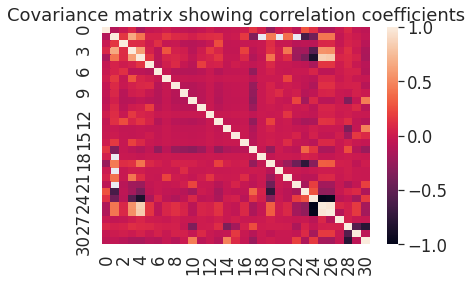

In [12]:
cor=df.corr()
sns.set(font_scale=1.5)
hm = sns.heatmap(cor.to_numpy(),
                 cbar=True,
                 fmt='.2f',
                 annot_kws={'size': 24},
                )
plt.title('Covariance matrix showing correlation coefficients')
plt.show()

In [13]:
indices = np.argwhere(np.abs(cor.to_numpy())>0.85)
indices.shape
temp_list=[]
for i,j in zip(indices[:,0],indices[:,1]):
  if i != j :
    temp_list.append((i,j))
temp_list

    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


[(24, 25), (24, 26), (25, 24), (25, 26), (26, 24), (26, 25)]

In [14]:
''' 
This part is optional and requires further investigating
'''
#df_scaled = np.delete(df_scaled,24,axis=1)
#df_scaled.shape

' \nThis part is optional and requires further investigating\n'

We can now proceed to apply PCA

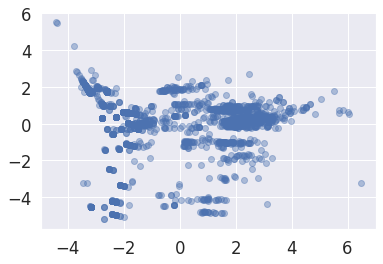

In [15]:
pca=PCA()
pca.fit(df_scaled)
df=pca.transform(df_scaled)
plt.scatter(df[:,0],df[:,1],alpha=0.4)
plt.show()


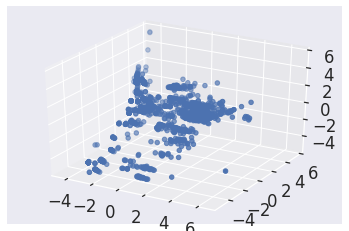

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[:,0],df[:,1],df[:,1])
plt.show()

We can now see the clusters ( dense blue ), We can apply KMeans for instance to cluster them. 

We can use the elbow rule to determine the most probable number of significant clusters. 

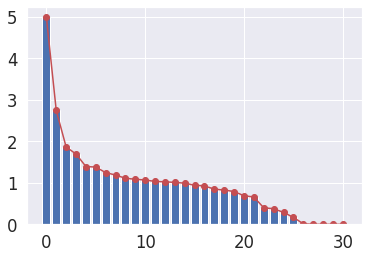

In [17]:
eigenvalues = pca.explained_variance_
plt.bar(np.arange(0,31,1), eigenvalues)
plt.plot(eigenvalues, "r")
plt.plot(eigenvalues, "ro")
plt.show()

Using the elbow rule we have two possible choices, either 21 clusters or 25 clusters, we will try both.

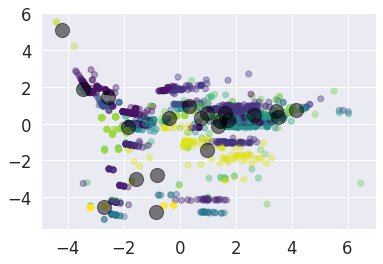

In [18]:
kmeans = KMeans(n_clusters = 21)
kmeans.fit(df)
clusters = kmeans.predict(df)

plt.scatter(df[:,0],df[:,1], c = clusters,alpha=0.4, cmap = 'viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5)

        

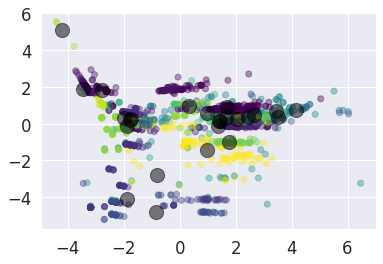

In [19]:
kmeans = KMeans(n_clusters = 25)
kmeans.fit(df)
clusters = kmeans.predict(df)

plt.scatter(df[:,0],df[:,1], c = clusters,alpha=0.4, cmap = 'viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5)

Both choices give pretty close results. 

Now we want to retreive the clustered ads so we'll create a dataframe mapping each ad to its respective cluster.

In [20]:
id=np.array(id)

labels = kmeans.labels_

Labeled_IDs=pd.DataFrame({"ID":id,"Real estate label":labels})

Labeled_IDs.head()


,ID,Real estate label
0,22c05930-0eb5-11e7-b53d-bbead8ba43fe,22
1,8d092fa0-bb99-11e8-a7c9-852783b5a69d,24
2,44b6a5c0-3466-11e9-8213-25cc7d9bf5fc,10
3,e9e07ed0-812f-11e8-82aa-61eacebe4584,1
4,872302b0-5a21-11e9-950c-510fefc1ed35,10


In [21]:
Labeled_IDs.loc[Labeled_IDs["Real estate label"]==10]

,ID,Real estate label
2,44b6a5c0-3466-11e9-8213-25cc7d9bf5fc,10
4,872302b0-5a21-11e9-950c-510fefc1ed35,10
267,782f5ac0-a737-11e9-96d9-fb3253f8fc6c,10
292,82ea5180-9289-11e9-a7f2-f5443208fc78,10
372,bdb404e0-d705-11e8-a22a-f5ef01c5fcae,10
432,138e7140-9d1f-11e9-ab3e-47ec2b68d334,10
502,89467920-5f6a-11e9-8084-55ce2049f05c,10
504,f99cd5d0-30c0-11e9-8330-99e77f092ba1,10
677,2cdb0260-9c09-11e9-af77-a17d8c291169,10
794,da10db80-9687-11e9-bba5-076f63900c40,10




Now we can assume that with high probability individuals belonging to the same cluster are likely about the same real estate, nevertheless this can be not totally accurate as some real estates might be very similar but not the same, for example 3 parking lot spaces for rant can have the same surface area, the same price and many other similar features but are not the same parking lots in reality, which can compermise the accuracy of our clustering. 
 
**Possible improvments**



*   Our first intuition is to do some feature engineering and label the data, putting us in the case of supervised learning in which we can do a much better job of classification using ensemble methods such as random forests , bagging, gradient boosting...etc, and the fact that there are a lot of easily interpretable metrics we can use in that case.
*   A second approach could be by exploiting the "DESCRIPTION" feature in our dataframe and using some NLP magic we can theoratically create a probabilistic model returning based on description which ads are more likely to be about the same real estate.
*   It will be better to insert all the transformations we did to the data frame and the later clustering into an scikit learn pipeline to avoid any unwanted problems.



